Features and labels saved to features_and_labels.pkl
KD-Tree saved to kd_tree.pkl
Query 1:
  Label: Leopards
  Recall: 1.0000
  Average Precision (AP): 1.0000
Query 2:
  Label: brain
  Recall: 0.3000
  Average Precision (AP): 0.5873
Query 3:
  Label: airplanes
  Recall: 0.4000
  Average Precision (AP): 0.3048
Query 4:
  Label: Motorbikes
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 5:
  Label: Faces
  Recall: 0.7000
  Average Precision (AP): 0.8976
Query 6:
  Label: bass
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 7:
  Label: crab
  Recall: 0.2000
  Average Precision (AP): 0.2083
Query 8:
  Label: beaver
  Recall: 0.1000
  Average Precision (AP): 0.2000
Query 9:
  Label: soccer_ball
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 10:
  Label: sea_horse
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 11:
  Label: gramophone
  Recall: 0.2000
  Average Precision (AP): 0.7500
Query 12:
  Label: airplanes
  Recall: 0.4000
  Average Precision (AP): 0.70

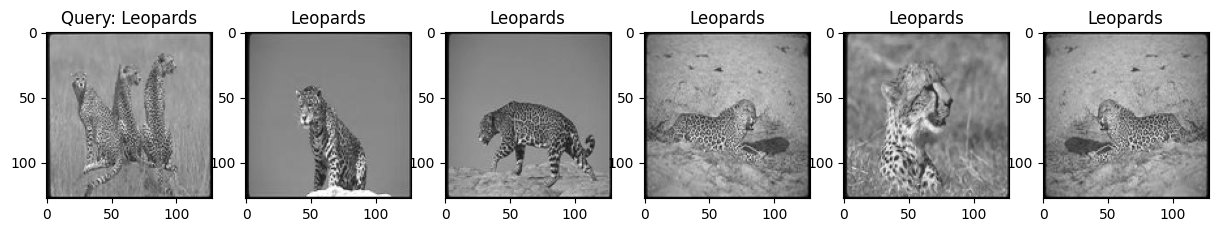

In [1]:
import os
import pickle
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.metrics import average_precision_score, recall_score
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Constants
data_dir = "/kaggle/input/caltech-101/caltech-101"
image_size = (128, 128)  # Resize images to 128x128 for uniformity
pickle_file = "features_and_labels.pkl"
kdtree_file = "kd_tree.pkl"

# Step 1: Load Caltech101 dataset and extract features
def load_and_extract_features(data_dir, image_size, pickle_file):
    features, labels = [], []
    label_map = {}
    label_counter = 0

    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue

        if category not in label_map:
            label_map[category] = label_counter
            label_counter += 1

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                image = imread(image_path, as_gray=True)
                image_resized = resize(image, image_size).flatten()
                features.append(image_resized)
                labels.append(category)  # Store category name as label
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    data = {
        "features": np.array(features),
        "labels": np.array(labels),
        "label_map": label_map
    }
    with open(pickle_file, "wb") as f:
        pickle.dump(data, f)
    print(f"Features and labels saved to {pickle_file}")

# Step 2: Load features and labels from pickle
if not os.path.exists(pickle_file):
    load_and_extract_features(data_dir, image_size, pickle_file)

with open(pickle_file, "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
label_map = data["label_map"]

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 4: Build or load KD-Tree
if not os.path.exists(kdtree_file):
    kd_tree = KDTree(X_train)
    with open(kdtree_file, "wb") as f:
        pickle.dump(kd_tree, f)
    print(f"KD-Tree saved to {kdtree_file}")
else:
    with open(kdtree_file, "rb") as f:
        kd_tree = pickle.load(f)
    print(f"KD-Tree loaded from {kdtree_file}")

# Step 5: Image retrieval function
def retrieve_images(query_image, k=5):
    dist, indices = kd_tree.query(query_image.reshape(1, -1), k=k)
    return indices[0], dist[0]

# Step 6: Evaluation
recall_values = []
average_precisions = []

for i, query_image in enumerate(X_test):
    query_label = y_test[i]
    retrieved_indices, _ = retrieve_images(query_image, k=10)
    retrieved_labels = y_train[retrieved_indices]

    # Compute recall
    true_positive_count = sum(1 for label in retrieved_labels if label == query_label)
    recall = true_positive_count / len(retrieved_labels)
    recall_values.append(recall)

    # Compute average precision only if there are positive matches
    true_labels = (retrieved_labels == query_label).astype(int)
    if np.sum(true_labels) > 0:  # Check if there are any positive labels
        scores = np.linspace(1, 0, len(true_labels))  # Simulated similarity scores
        ap = average_precision_score(true_labels, scores)
    else:
        ap = 0  # Set average precision to 0 if no positive class is found
    average_precisions.append(ap)

    # Print recall and AP for the current query
    print(f"Query {i + 1}:")
    print(f"  Label: {query_label}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Average Precision (AP): {ap:.4f}")

# Overall metrics
mean_recall = np.mean(recall_values)
mean_ap = np.mean(average_precisions)

print(f"Overall Metrics:")
print(f"  Mean Recall: {mean_recall:.4f}")
print(f"  Mean Average Precision (mAP): {mean_ap:.4f}")



# Step 7: Visualization
query_index = 0  # Example query image index
query_image = X_test[query_index]
retrieved_indices, _ = retrieve_images(query_image, k=5)

plt.figure(figsize=(15, 5))

# Display query image
plt.subplot(1, 6, 1)
plt.imshow(query_image.reshape(image_size), cmap='gray')
plt.title(f"Query: {y_test[query_index]}")

# Display retrieved images
for i, idx in enumerate(retrieved_indices):
    plt.subplot(1, 6, i + 2)
    plt.imshow(X_train[idx].reshape(image_size), cmap='gray')
    plt.title(f"{y_train[idx]}")

plt.show()


In [2]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 65.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Features and labels saved to features_and_labels2.pkl
FAISS index saved to faiss_index.bin
Query 1:
  Label: Leopards
  Recall: 1.0000
  Average Precision (AP): 1.0000
Query 2:
  Label: brain
  Recall: 0.3000
  Average Precision (AP): 0.5873
Query 3:
  Label: airplanes
  Recall: 0.4000
  Average Precision (AP): 0.3048
Query 4:
  Label: Motorbikes
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 5:
  Label: Faces
  Recall: 0.7000
  Average Precision (AP): 0.8976
Query 6:
  Label: bass
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 7:
  Label: crab
  Recall: 0.2000
  Average Precision (AP): 0.2083
Query 8:
  Label: beaver
  Recall: 0.1000
  Average Precision (AP): 0.2000
Query 9:
  Label: soccer_ball
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 10:
  Label: sea_horse
  Recall: 0.0000
  Average Precision (AP): 0.0000
Query 11:
  Label: gramophone
  Recall: 0.2000
  Average Precision (AP): 0.7500
Query 12:
  Label: airplanes
  Recall: 0.4000
  Average Precision (

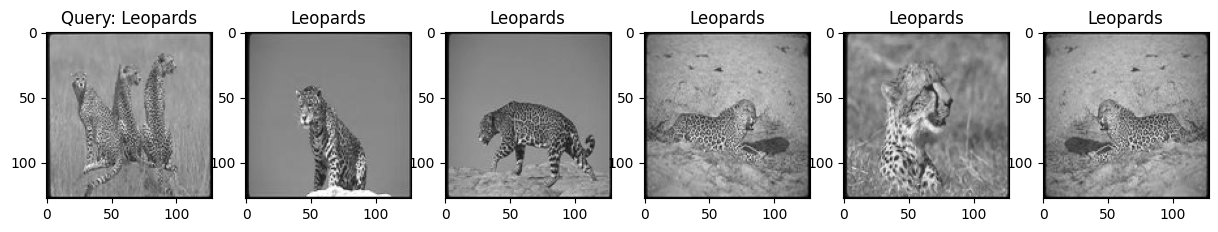

In [3]:
import os
import pickle
import numpy as np
import faiss  # Import FAISS
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Constants
data_dir = "/kaggle/input/caltech-101/caltech-101"
image_size = (128, 128)
pickle_file = "features_and_labels2.pkl"
faiss_index_file = "faiss_index.bin"

# Step 1: Load Caltech101 dataset and extract features (unchanged)
def load_and_extract_features(data_dir, image_size, pickle_file):
    features, labels = [], []
    label_map = {}
    label_counter = 0

    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue

        if category not in label_map:
            label_map[category] = label_counter
            label_counter += 1

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                image = imread(image_path, as_gray=True)
                image_resized = resize(image, image_size).flatten()
                features.append(image_resized)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    data = {
        "features": np.array(features).astype('float32'),  # FAISS requires float32
        "labels": np.array(labels),
        "label_map": label_map
    }
    with open(pickle_file, "wb") as f:
        pickle.dump(data, f)
    print(f"Features and labels saved to {pickle_file}")

# Step 2: Load features and labels
if not os.path.exists(pickle_file):
    load_and_extract_features(data_dir, image_size, pickle_file)

with open(pickle_file, "rb") as f:
    data = pickle.load(f)

features = data["features"]
labels = data["labels"]
label_map = data["label_map"]

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 4: Build or load FAISS index
if not os.path.exists(faiss_index_file):
    faiss_index = faiss.IndexFlatL2(X_train.shape[1])  # L2 distance
    faiss_index.add(X_train)  # Add training features to the index
    faiss.write_index(faiss_index, faiss_index_file)
    print(f"FAISS index saved to {faiss_index_file}")
else:
    faiss_index = faiss.read_index(faiss_index_file)
    print(f"FAISS index loaded from {faiss_index_file}")

# Step 5: Image retrieval function using FAISS
def retrieve_images(query_image, k=5):
    query_image = query_image.reshape(1, -1).astype('float32')  # Ensure float32
    distances, indices = faiss_index.search(query_image, k)
    return indices[0], distances[0]

# Step 6: Evaluation
recall_values = []
average_precisions = []

for i, query_image in enumerate(X_test):
    query_label = y_test[i]
    retrieved_indices, _ = retrieve_images(query_image, k=10)
    retrieved_labels = y_train[retrieved_indices]

    # Compute recall
    true_positive_count = sum(1 for label in retrieved_labels if label == query_label)
    recall = true_positive_count / len(retrieved_labels)
    recall_values.append(recall)

    # Compute average precision
    true_labels = (retrieved_labels == query_label).astype(int)
    if np.sum(true_labels) > 0:
        scores = np.linspace(1, 0, len(true_labels))  # Simulated similarity scores
        ap = average_precision_score(true_labels, scores)
    else:
        ap = 0
    average_precisions.append(ap)

    print(f"Query {i + 1}:")
    print(f"  Label: {query_label}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Average Precision (AP): {ap:.4f}")

# Overall metrics
mean_recall = np.mean(recall_values)
mean_ap = np.mean(average_precisions)

print(f"Overall Metrics:")
print(f"  Mean Recall: {mean_recall:.4f}")
print(f"  Mean Average Precision (mAP): {mean_ap:.4f}")

# Step 7: Visualization
query_index = 0
query_image = X_test[query_index]
retrieved_indices, _ = retrieve_images(query_image, k=5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(query_image.reshape(image_size), cmap='gray')
plt.title(f"Query: {y_test[query_index]}")

for i, idx in enumerate(retrieved_indices):
    plt.subplot(1, 6, i + 2)
    plt.imshow(X_train[idx].reshape(image_size), cmap='gray')
    plt.title(f"{y_train[idx]}")

plt.show()
